# Data Visualization

This notebook is just going to be used for visualizing the radar data so that we can see how the data is structured for further use

In [1]:
## Imports

# Data Handling
import bz2
import sys, os
import pyart
from pyproj import Proj
import numpy as np

# Graphing
import matplotlib.pyplot as plt
from pyart.graph import RadarDisplay
import cartopy.crs as ccrs
import cartopy.feature as cfeature



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
# Defining the data file and opening the data
# Define the path to the data file
root_dir = '../'
data_path = 'data/'
file = "KJAX_latest_scan.bin"  # Replace with your file name
file_path = f"{root_dir}{data_path}{file}"
file_path = os.path.join(root_dir, data_path, file)

# Try to read the file using Py-ART
try:
    radar = pyart.io.read_nexrad_archive(file_path)
    print("Radar data loaded successfully.")
    #print(radar)  # Print radar object details

    # Example: Access radar attributes
    print(f"Station: {radar.metadata['instrument_name']}\tLatitude: {radar.latitude['data'][0]}, Longitude: {radar.longitude['data'][0]}")  # Station name
    print("Radar fields:", radar.fields.keys())
    print("Radar elevation angles:", radar.elevation['data'])
    print(f"Number of sweeps: {len(radar.sweep_number['data'])}")
except Exception as e:
    print(f"Error reading radar file: {e}")


Radar data loaded successfully.
Station: KJAX	Latitude: 30.48463249206543, Longitude: -81.70189666748047
Radar fields: dict_keys(['clutter_filter_power_removed', 'cross_correlation_ratio', 'reflectivity', 'velocity', 'differential_reflectivity', 'spectrum_width', 'differential_phase'])
Radar elevation angles: [0.5465698  0.5548096  0.5355835  ... 0.92285156 0.92285156 0.92285156]
Number of sweeps: 3


In [3]:
radar.get_field(0, 'reflectivity')

masked_array(
  data=[[0.0, 1.0, 1.5, ..., --, --, --],
        [-5.0, -5.5, -6.0, ..., --, --, --],
        [-12.5, -7.0, -8.0, ..., --, --, --],
        ...,
        [--, -7.0, -13.5, ..., --, --, --],
        [--, -6.0, -13.5, ..., --, --, --],
        [28.5, 9.0, -12.0, ..., --, --, --]],
  mask=[[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [ True, False, False, ...,  True,  True,  True],
        [ True, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]],
  fill_value=np.float64(1e+20),
  dtype=float32)

## Converting data onto Lat/Lon grid

In [4]:
# Define grid parameters
grid_shape = (1, 500, 500)  # (vertical levels, lat points, lon points)
grid_limits = ((0, 2000), (-150000, 150000), (-150000, 150000))  # Height in meters, lat/lon limits in meters

# Perform grid conversion
grid = pyart.map.grid_from_radars(
    radar, 
    grid_shape=grid_shape, 
    grid_limits=grid_limits,
    fields=['reflectivity']  # Replace with desired field
)

# Inspect grid metadata
print("Grid Metadata:")
print(f"Grid shape: {grid.fields['reflectivity']['data'].shape}")
print(f"Grid center: {grid.origin_latitude['data'][0]}, {grid.origin_longitude['data'][0]}")


Grid Metadata:
Grid shape: (1, 500, 500)
Grid center: 30.48463249206543, -81.70189666748047


## Plotting data

In [5]:
# Extract data
lat = grid.point_latitude['data']
lon = grid.point_longitude['data']
reflectivity = grid.fields['reflectivity']['data'][0]  # Single vertical level

In [6]:
np.shape(lat.squeeze()), np.shape(lon.squeeze()), np.shape(reflectivity)
lon.squeeze()[:][0].min(), lon.squeeze()[:][0].max(), lat.squeeze()[0][:].min(), lat.squeeze()[-1][:].max()
#radar.time['units'].split(' ')[-1] 

(np.float64(-83.24605794651985),
 np.float64(-80.15773538844108),
 np.float64(29.126550834698516),
 np.float64(31.833615497571095))

In [7]:
# Function used to create the map subplot backgrounds over a specified subdomain
def plot_subset_background(ax, lonmin, lonmax, latmin, latmax):
    ax.set_extent([lonmin, lonmax, latmin, latmax])
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    return ax

Text(0.5, 1.0, 'KJAX Reflectivity at 2025-01-27T20:09:49Z')

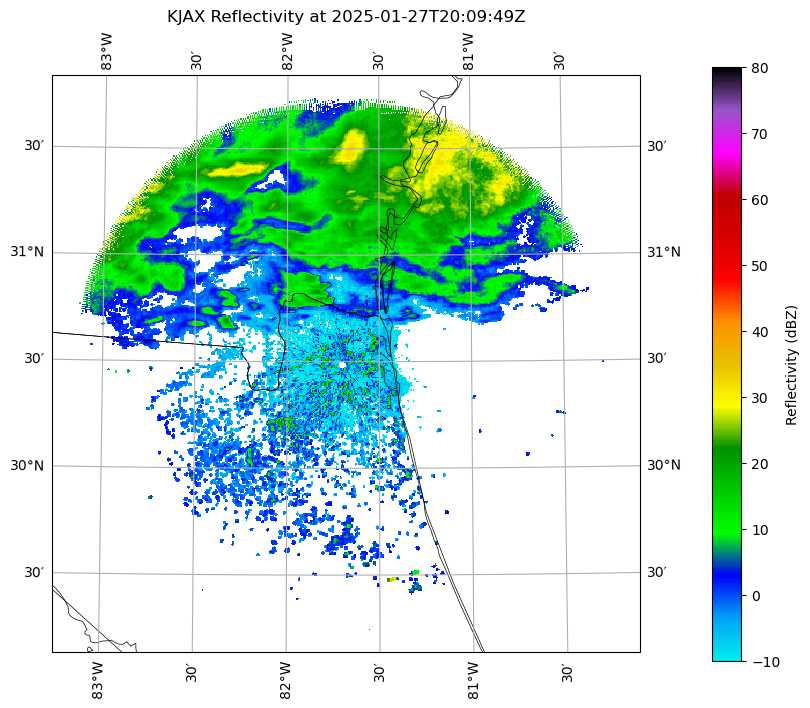

In [8]:
# Plot
crs = ccrs.LambertConformal(central_longitude=radar.longitude['data'][0])

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8),constrained_layout=True,
                            subplot_kw={'projection': crs})
plot_subset_background(axes, lon.squeeze()[:][0].min(), lon.squeeze()[:][-1].max(), lat.squeeze()[0][:].min(), lat.squeeze()[-1][:].max())
cb1 = axes.pcolormesh(lon.squeeze(), lat.squeeze(), reflectivity, shading='auto', cmap='pyart_NWSRef', vmin=-10, vmax=80, transform=ccrs.PlateCarree())
fig.colorbar(cb1, ax = axes, shrink=0.75).set_label('Reflectivity (dBZ)')
axes.set_xlabel('Longitude')
axes.set_ylabel('Latitude')
axes.set_title('%s Reflectivity at %s'%(radar.metadata['instrument_name'],radar.time['units'].split(' ')[-1] ))
